In [2]:

from pathlib import Path
import torch
from PIL import Image
from timm.data import create_transform, resolve_data_config
import glob
import os
from wdv3_timm import MODEL_REPO_MAP
from configs import ScriptOptions
from model import ensure_model_folder, download_model_files, load_model_local_or_remote, load_labels_local_or_remote, load_yolo_model
from detection import load_detectors_config
from tagging import process_image_with_multiple_detectors
from preprocess import merge_tags_from_regions, save_results_to_json
import matplotlib as plt
from visualization import view_image_results







def save_tags_to_txt(image_path, merged_tags, append_tags=False):
    """
    Сохраняет объединенные теги в TXT файл рядом с изображением.
    
    Args:
        image_path: Путь к изображению
        merged_tags: Словарь с объединенными тегами
        append_tags: Если True, добавляет новые теги к существующим; иначе перезаписывает
        
    Returns:
        str: Путь к созданному/обновленному TXT файлу
    """
    # Получаем путь для TXT файла (заменяем расширение на .txt)
    txt_path = os.path.splitext(image_path)[0] + ".txt"
    
    # Получаем список тегов из объединенных результатов
    # Используем taglist, где теги разделены пробелами (без подчеркиваний)
    tags_to_save = merged_tags["taglist"].split(", ")
    
    # Если нужно добавить к существующим тегам
    if append_tags and os.path.exists(txt_path):
        try:
            # Читаем существующие теги
            with open(txt_path, 'r', encoding='utf-8') as f:
                existing_content = f.read().strip()
                
            # Разделяем существующие теги (они могут быть разделены запятыми, запятыми с пробелами, или новыми строками)
            if ", " in existing_content:
                existing_tags = [tag.strip() for tag in existing_content.split(", ")]
            elif "," in existing_content:
                existing_tags = [tag.strip() for tag in existing_content.split(",")]
            else:
                existing_tags = [tag.strip() for tag in existing_content.split("\n") if tag.strip()]
            
            # Объединяем старые и новые теги, убираем дубликаты
            existing_tags_set = set(existing_tags)
            new_tags = [tag for tag in tags_to_save if tag not in existing_tags_set]
            
            # Если есть новые теги для добавления
            if new_tags:
                all_tags = existing_tags + new_tags
                # Сортируем теги для удобства
                all_tags.sort()
                
                # Сохраняем обновленный список
                with open(txt_path, 'w', encoding='utf-8') as f:
                    f.write(", ".join(all_tags))
                
                print(f"Добавлено {len(new_tags)} новых тегов в {txt_path}")
            else:
                print(f"Новых тегов не обнаружено для {txt_path}")
                
        except Exception as e:
            print(f"Ошибка при добавлении тегов к {txt_path}: {e}")
            # В случае ошибки создадим новый файл с тегами
            with open(txt_path, 'w', encoding='utf-8') as f:
                f.write(", ".join(tags_to_save))
            print(f"Создан новый файл с тегами: {txt_path}")
    else:
        # Просто создаем новый файл с тегами
        with open(txt_path, 'w', encoding='utf-8') as f:
            f.write(", ".join(tags_to_save))
        print(f"Создан файл с тегами: {txt_path}")
    
    return txt_path


def BatchTagging(opts: ScriptOptions):
    if opts.model not in MODEL_REPO_MAP:
        print(f"Доступные модели: {list(MODEL_REPO_MAP.keys())}")
        raise ValueError(f"Неизвестная модель: {opts.model}")
    
    repo_id = MODEL_REPO_MAP[opts.model]
    image_folder = Path(opts.ImageFolder).resolve()
    if not image_folder.is_dir():
        raise FileNotFoundError(f"Директория не найдена: {image_folder}")
    
    # Создаем папку для моделей тегирования, если она не существует
    model_folder = ensure_model_folder(Path(opts.model_folder))
    
    # Создаем папку для моделей YOLO, если она не существует
    yolo_model_dir = ensure_model_folder(Path(opts.yolo_model_dir))
    
    # Загружаем или скачиваем файлы модели тегирования
    download_model_files(repo_id, model_folder)
    
    # Загружаем модель из локальной папки или из Hub
    print(f"Загрузка модели тегирования '{opts.model}' из '{repo_id}'...")
    tagger_model = load_model_local_or_remote(repo_id, model_folder)
    
    # Загружаем теги из локальной папки или из Hub
    print("Загрузка списка тегов...")
    labels = load_labels_local_or_remote(repo_id, model_folder)
    
    print("Создание трансформации данных...")
    transform = create_transform(**resolve_data_config(tagger_model.pretrained_cfg, model=tagger_model))
    
    # Загружаем конфигурацию детекторов
    print(f"Загрузка конфигурации детекторов из {opts.detectors_config}...")
    detectors = load_detectors_config(opts.detectors_config)
    
    # Загружаем все уникальные модели YOLO
    yolo_models = {}
    for detector in detectors:
        if detector.model_path not in yolo_models:
            print(f"Загрузка модели YOLO {detector.model_path}...")
            try:
                # Используем новую функцию для загрузки YOLO модели
                yolo_models[detector.model_path] = load_yolo_model(detector.model_path, yolo_model_dir)
            except Exception as e:
                print(f"Ошибка загрузки модели YOLO {detector.model_path}: {e}")
                print(f"Детектор {detector.name} будет пропущен")
    
    # Получаем список изображений
    if opts.recursive:
        image_files = list(image_folder.rglob("*.jpg")) + list(image_folder.rglob("*.jpeg")) + list(image_folder.rglob("*.png"))
    else:
        image_files = list(image_folder.glob("*.jpg")) + list(image_folder.glob("*.jpeg")) + list(image_folder.glob("*.png"))
    
    if not image_files:
        print("Изображения не найдены в указанной директории.")
        return
    
    torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tagger_model = tagger_model.to(torch_device)
    
    all_results = []
    all_merged_results = []
    total_images = len(image_files)
    
    print(f"Всего изображений для обработки: {total_images}")
    
    for i, img_path in enumerate(image_files):
        print(f"\nОбработка изображения {i+1}/{total_images}: {img_path}")
        
        # Обрабатываем изображение со всеми детекторами
        result = process_image_with_multiple_detectors(
            str(img_path),
            tagger_model,
            transform,
            labels,
            detectors,
            yolo_models,
            opts.gen_threshold,
            opts.char_threshold,
            torch_device
        )
        
        if result:
            all_results.append(result)
            
            # Объединяем теги из всех источников
            merged_tags = merge_tags_from_regions(result, detectors)
            
            # Добавляем информацию о результатах для текущего изображения
            merged_result = {
                "image_path": result["image_path"],
                "merged_tags": merged_tags
            }
            all_merged_results.append(merged_result)
            
            # Если включена опция сохранения в TXT, сохраняем теги в отдельный файл
            if opts.save_txt:
                txt_path = save_tags_to_txt(
                    result["image_path"], 
                    merged_tags, 
                    append_tags=opts.append_txt
                )
                # Добавляем путь к TXT файлу в результаты
                merged_result["txt_path"] = txt_path
            
            # Выводим информацию о результатах
            print("--------")
            print(f"Путь к изображению: {result['image_path']}")
            print("\nРезультаты для полного изображения:")
            print(f"Описание: {result['full_image']['caption']}")
            print(f"Теги: {result['full_image']['taglist']}")
            
            # Выводим информацию о найденных областях для каждого детектора
            for detector_name, regions in result["detectors"].items():
                if regions:
                    print(f"\nДетектор {detector_name}: найдено областей: {len(regions)}")
                    for region in regions:
                        print(f"  Область {region['region_id']+1}, координаты: {region['bbox']}")
                        print(f"  Описание: {region['caption']}")
                        print(f"  Теги: {region['taglist']}")
                else:
                    print(f"\nДетектор {detector_name}: областей не найдено")
            
            # Выводим объединенные теги
            print("\nОбъединенные теги:")
            print(f"Описание: {merged_tags['caption']}")
            print(f"Теги: {merged_tags['taglist']}")
            
            # Если сохранили в TXT, показываем информацию
            if opts.save_txt:
                if opts.append_txt:
                    print(f"Теги добавлены/обновлены в: {merged_result['txt_path']}")
                else:
                    print(f"Теги сохранены в: {merged_result['txt_path']}")
            
            print("--------")
    
    print(f"\nОбработка завершена. Обработано изображений: {len(all_results)}/{total_images}")
    
    # Сохраняем результаты в файл
    if opts.output_file:
        save_results_to_json(all_results, opts.output_file)
        
        # Также сохраняем объединенные результаты
        merged_output = os.path.splitext(opts.output_file)[0] + "_merged" + os.path.splitext(opts.output_file)[1]
        save_results_to_json(all_merged_results, merged_output)
    
    return all_results, all_merged_results



# Пример конфига для настройки yolo моделей и обработки рещультата областей
EXAMPLE_DETECTORS_CONFIG = [
    {
        "name": "person_detector",
        "model_path": "yolov8n.pt",
        "confidence": 0.25,
        "classes": [0],
        "remove_tags_from_full": ["1girl", "1boy"],
        "remove_tags_from_region": ["multiple views"],
        "add_tags_to_region": {"person": 1.0},
        "exclude_from_region": ["close-up", "cowboy_shot", "full_body"],
        "specific_excluded_tags": [],
        "region_gen_threshold": 0.4,  # Более строгий для регионов
        "region_char_threshold": 0.8
    },
    {
        "name": "face_detector",
        "model_path": "yolov8n-face.pt",
        "confidence": 0.3,
        "classes": [0],
        "remove_tags_from_full": ["face"],
        "remove_tags_from_region": ["full body"],
        "add_tags_to_region": {"face": 1.0},
        "exclude_from_region": ["1girl", "portrait", "upper_body"],
        "specific_excluded_tags": ["blue_eyes", "green_eyes", "yellow_eyes", "smile"],
        "region_gen_threshold": 0.5,  # Ещё строже для лиц
        "region_char_threshold": 0.85
    },
    {
        "name": "building_detector",
        "model_path": "yolov8n-buildings.pt",
        "confidence": 0.25,
        "classes": [67],
        "remove_tags_from_full": ["building"],
        "remove_tags_from_region": ["multiple views"],
        "add_tags_to_region": {"building": 1.0},
        "exclude_from_region": ["close-up", "portrait"],
        "specific_excluded_tags": ["window", "door"],
        "region_gen_threshold": 0.45,  # Пример для зданий
        "region_char_threshold": 0.75  # Оставим как у полной картинки
    }
]


In [3]:
params= ScriptOptions(
    os.path.join(os.getcwd(), 'TestPic'),
    'vit',
    0.35,
    0.75,
    2,
    False
)



In [4]:
result=BatchTagging(params)

Файл pytorch_model.bin уже существует в models\taggers\wd-vit-tagger-v3
Файл config.json уже существует в models\taggers\wd-vit-tagger-v3
Файл model.safetensors уже существует в models\taggers\wd-vit-tagger-v3
Файл selected_tags.csv уже существует в models\taggers\wd-vit-tagger-v3
Загрузка модели тегирования 'vit' из 'SmilingWolf/wd-vit-tagger-v3'...
Loading model from models\taggers\wd-vit-tagger-v3\model.safetensors using safetensors
Загрузка списка тегов...
Загрузка тегов из локального файла: models\taggers\wd-vit-tagger-v3\selected_tags.csv
Создание трансформации данных...
Загрузка конфигурации детекторов из detectors.json...
Загрузка модели YOLO yolov8n.pt...
Loading YOLO model from specified path: yolov8n.pt
Загрузка модели YOLO face_yolov8n.pt...
Loading YOLO model from local directory: models\yolo\face_yolov8n.pt
Всего изображений для обработки: 4

Обработка изображения 1/4: C:\Users\liali\YoloWdTagger\wdv3-timm\TestPic\test1.png

image 1/1 C:\Users\liali\YoloWdTagger\wdv3-timm

In [5]:
# result[0][x] - теги по областям, для общей области, путь до изображения, какие детекторы и box для них Для Изображения X
# result[1][x] - обьедененые теги + путь до изображения X
print(result[1][0].keys())
print()
print(result[0][0].keys())
print()
print(result[1][0]['merged_tags'].keys())

dict_keys(['image_path', 'merged_tags', 'txt_path'])

dict_keys(['image_path', 'full_image', 'detectors'])

dict_keys(['caption', 'taglist', 'general', 'character', 'ratings'])


In [6]:
print(result[1][3]['merged_tags']['caption'])
print()
print(result[1][3]['merged_tags']['taglist'])

1boy, 1girl, ^^^, ahoge, back, black_hair, blonde_hair, blue_shorts, blurry, blush_stickers, building, chair, crossed_arms, denim, depth_of_field, desk, dress, facing_away, from_behind, indian_style, indoors, letterboxed, long_hair, long_legs, looking_at_viewer, multicolored_hair, oshino_shinobu, outdoors, person, sandals, school_desk, short_hair, shorts, sitting, topless, topless_male, tree, white_dress, white_footwear, yellow_eyes

1boy, 1girl, ^^^, ahoge, back, black hair, blonde hair, blue shorts, blurry, blush stickers, building, chair, crossed arms, denim, depth of field, desk, dress, facing away, from behind, indian style, indoors, letterboxed, long hair, long legs, looking at viewer, multicolored hair, oshino shinobu, outdoors, person, sandals, school desk, short hair, shorts, sitting, topless, topless male, tree, white dress, white footwear, yellow eyes


In [7]:
print(result[0][1]['full_image']['taglist'])
print()
print(result[1][1]['merged_tags']['taglist'])

1girl, long hair, solo, hat, blush stickers, blonde hair, yellow eyes, sword, weapon, bandaid, fang, bandaid on leg, jewelry, bracelet, bandaid on knee, jacket on shoulders, pointy ears, jacket, peaked cap, crossed arms, cosplay, oshino shinobu

1girl, bandaid, bandaid on knee, bandaid on leg, blonde hair, blush stickers, bracelet, coat, cosplay, crossed arms, dress, fang, fang out, hat, jacket, jacket on shoulders, jewelry, katana, long hair, looking at viewer, ootachi, oshino shinobu, peaked cap, person, planted, planted sword, pointy ears, solo, sword, uniform, weapon, white dress, yellow eyes


In [8]:
print(result[0][1])


{'image_path': 'C:\\Users\\liali\\YoloWdTagger\\wdv3-timm\\TestPic\\test2.png', 'full_image': {'caption': '1girl, long_hair, solo, hat, blush_stickers, blonde_hair, yellow_eyes, sword, weapon, bandaid, fang, bandaid_on_leg, jewelry, bracelet, bandaid_on_knee, jacket_on_shoulders, pointy_ears, jacket, peaked_cap, crossed_arms, cosplay, oshino_shinobu', 'taglist': '1girl, long hair, solo, hat, blush stickers, blonde hair, yellow eyes, sword, weapon, bandaid, fang, bandaid on leg, jewelry, bracelet, bandaid on knee, jacket on shoulders, pointy ears, jacket, peaked cap, crossed arms, cosplay, oshino shinobu', 'ratings': {'general': 0.020479001, 'sensitive': 0.94882166, 'questionable': 0.018754274, 'explicit': 0.0003204916}, 'character': {'oshino_shinobu': 0.99428844}, 'general': {'1girl': 0.997795, 'long_hair': 0.97297716, 'solo': 0.97211087, 'hat': 0.9595949, 'blush_stickers': 0.9589741, 'blonde_hair': 0.9545653, 'yellow_eyes': 0.9322829, 'sword': 0.8894148, 'weapon': 0.882274, 'bandaid':

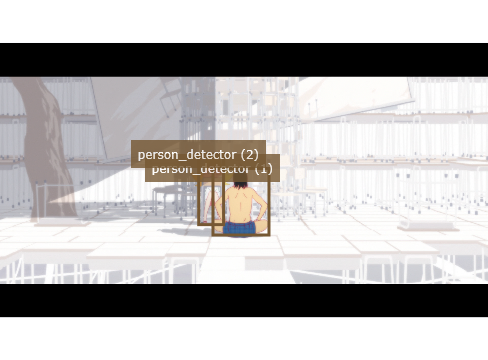

In [24]:
view_image_results(result, 3, visualize=True, save_visualization=False, verbose=False)